# Importing Necessary Libraries

In [1]:
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  cu111


In [2]:
# Some basic setup:
# Setup detectron2 logger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some necessary libraries
import numpy as np
import os, json, cv2, random
import fiftyone as fo
from PIL import Image
import time
import datetime
import logging
from collections import OrderedDict
import json

# import some common detectron2 utilities
import detectron2.utils.comm as comm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, hooks
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import GeneralizedRCNNWithTTA
from detectron2.config import CfgNode as CN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
# For Augmentations
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

# Preparing Training and Testing Datasets

In [3]:
register_coco_instances("CottonImaging_train", {}, 'TrainingSet.json', "training_images")
MetadataCatalog.get("CottonImaging_train").thing_classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]
MetadataCatalog.get("CottonImaging_train").thing_colors = [(0, 255, 0), (255, 0, 255), (0, 0, 255), (255, 0, 0)]
metadata_train = MetadataCatalog.get("CottonImaging_train")

In [4]:
register_coco_instances("CottonImaging_test", {}, "TestSet.json", "test_images")
MetadataCatalog.get("CottonImaging_test").thing_classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]
MetadataCatalog.get("CottonImaging_test").thing_colors = [(0, 255, 0), (255, 0, 255), (0, 0, 255), (255, 0, 0)]
metadata_test = MetadataCatalog.get("CottonImaging_test")

[12/11 16:35:47 d2.data.datasets.coco]: Loaded 281 images in COCO format from /home/avl/Projects/Cotton Imaging Project/Data/07_04_2022/TrainingSet_Dataset070422.json


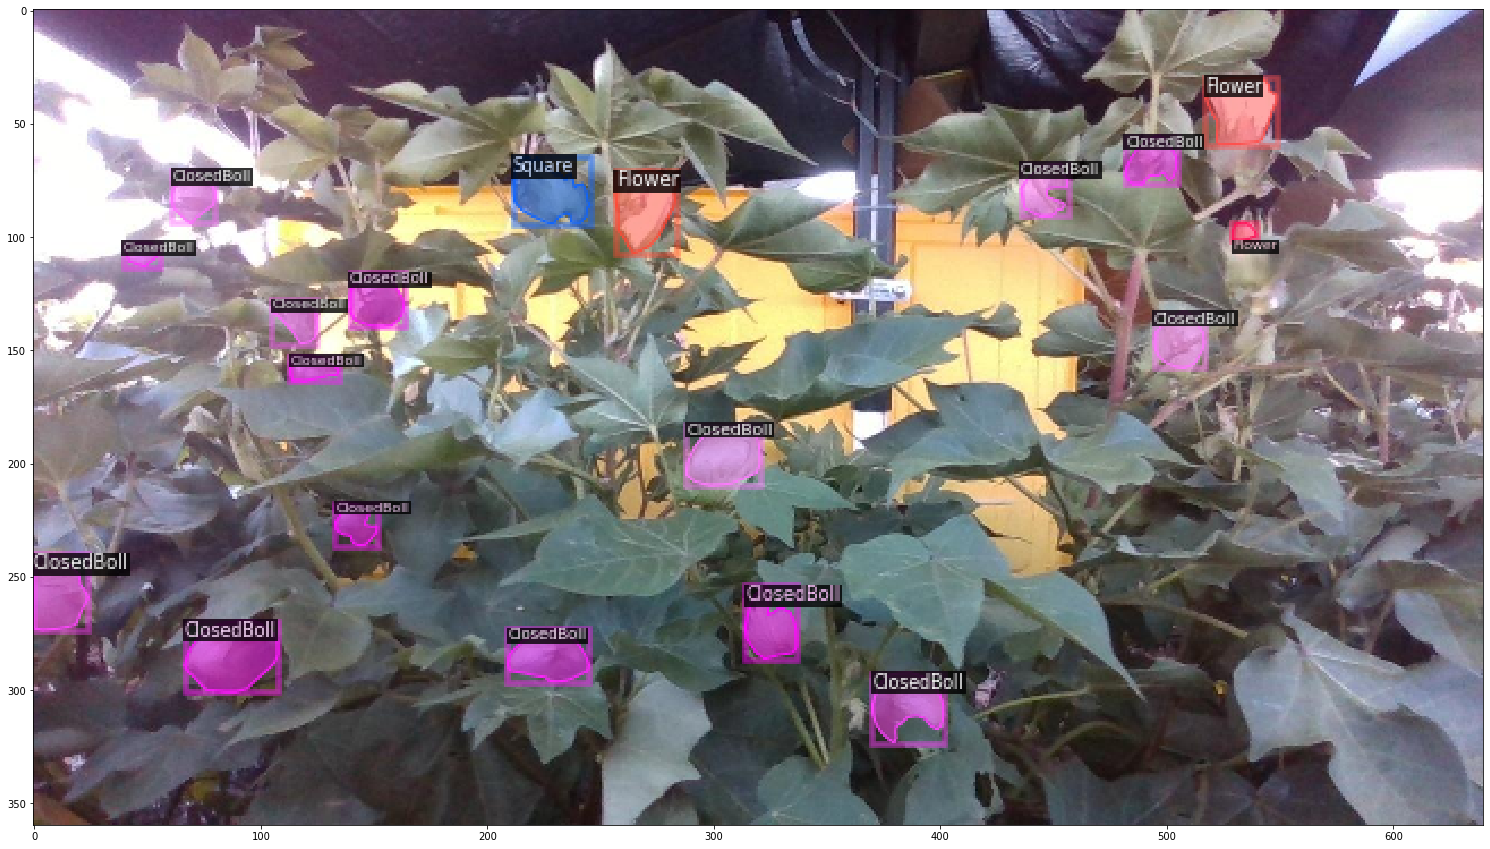

In [10]:
dataset_dicts = DatasetCatalog.get("CottonImaging_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata_train, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

# Train Model

### Define Custom Augmentations

In [ ]:
def mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    img = utils.read_image(dataset_dict["file_name"], format='BGR')
    utils.check_image_size(dataset_dict, img)
    
    # Augmentations
    auginput = T.AugInput(img)
    augs = T.AugmentationList([
        T.RandomBrightness(0.5, 2),
        T.RandomContrast(0.5, 2),
        T.RandomSaturation(0.5, 2),
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
        T.ResizeShortestEdge([640, 800], 1333),
        T.RandomCrop('relative_range', [0.9, 0.9]),
        T.RandomRotation([0, 90], expand=False)
    ])
    transform = augs(auginput)
    
    image = torch.from_numpy(auginput.image.transpose(2, 0, 1).copy())
    
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    
    instances = utils.annotations_to_instances(
        annos, img.shape[:2], mask_format="polygon"
    )
    
    instances.gt_boxes = instances.gt_masks.get_bounding_boxes()
    
    return {
       # create the format that the model expects
       "file_name": dataset_dict['file_name'],
       "height": 720,
       "width": 1280,
       "image_id": dataset_dict['image_id'],
       "image": image,
       "instances": utils.filter_empty_instances(instances)
    }

### Function to Save the Detectron2 Config into Disk

In [11]:
def cfg2yaml(cfg):
    
    with open(cfg.OUTPUT_DIR + "/Config.txt", 'w') as file:
        file.write(cfg.dump())
    
    os.rename(cfg.OUTPUT_DIR + "/Config.txt", cfg.OUTPUT_DIR + "/Config.yaml")

### Class to Evaluate the Validation Set During Training

In [ ]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

## Trainer Class

In [ ]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    
    @classmethod
    def build_train_loader(cls, cfg):
        
        return build_detection_train_loader(cfg, mapper=mapper)

## Setup Detectron2 Config

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.MASK_ON = True
cfg.DATASETS.TRAIN = ("CottonImaging_train",)
cfg.DATASETS.TEST = ("CottonImaging_test",)
cfg.TEST.EVAL_PERIOD = 200
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml") # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 14
cfg.SOLVER.BASE_LR = 0.00015  # Learning Rate
cfg.SOLVER.MAX_ITER = 15000
cfg.SOLVER.STEPS = (12500, 14000)
cfg.MODEL.RPN.NMS_THRESH = 0.6
#----------------------------------------------------------------------- FPN Options
cfg.MODEL.RPN.IN_FEATURES = ["p2", "p3", "p4", "p5", "p6"]
cfg.MODEL.ROI_HEADS.IN_FEATURES = ["p2", "p3", "p4", "p5", "p6"]
cfg.MODEL.RESNETS.OUT_FEATURES = ["res2", "res3", "res4", "res5"]
cfg.MODEL.FPN.IN_FEATURES = ["res2", "res3", "res4", "res5"]
#-----------------------------------------------------------------------
cfg.SOLVER.CHECKPOINT_PERIOD = 2500
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  
cfg.OUTPUT_DIR = "Output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
cfg2yaml(cfg)

trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)

trainer.train()

### Display Training and Validation Loss

In [ ]:
plt.rcParams['figure.figsize'] = [14, 7]
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')
plt.grid(True, which="both")
plt.semilogy(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.semilogy(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['training_loss', 'validation_loss'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')
plt.savefig(cfg.OUTPUT_DIR +  '/Loss Curve.png')
plt.show()

# Evaluate Model

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0015999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("CottonImaging_test", output_dir=cfg.OUTPUT_DIR,use_fast_impl=True)
val_loader = build_detection_test_loader(cfg, "CottonImaging_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

## Visualize Model Output and Performance

In [ ]:
dataset_dicts = DatasetCatalog.get("CottonImaging_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata_test, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

### Using FiftyOne

In [ ]:
dataset = fo.Dataset.from_dir(
    data_path= "test_images",
    labels_path='TestSet.json',
    dataset_type=fo.types.COCODetectionDataset,
    label_types=["detections", "segmentations"],
    label_field = "ground_truth",
)

In [ ]:
classes = ["OpenBoll", "ClosedBoll", "Flower", "Square"]

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(dataset):
        i = 1
        # Load image
        image = cv2.imread(sample.filepath)
        im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w , c = image.shape

        # Perform inference
        preds = predictor(image)
        labels = preds["instances"].pred_classes.cpu().detach().numpy()
        scores = preds["instances"].scores.cpu().detach().numpy()
        masks = preds["instances"].pred_masks.cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        segmentations = []
        for label, score, seg in zip(labels, scores, masks):

            segmentations.append(
                fo.Detection.from_mask(
                    mask=seg,
                    label=classes[label],
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["predictions"] = fo.Detections(detections=segmentations)
        sample.save()

print("Finished adding predictions")

In [ ]:
results = predictions_view.evaluate_detections(
    "predictions",
    gt_field="ground_truth_segmentations",
    eval_key="eval",
    compute_mAP=True,
    use_masks=True,
    classes= classes,
    iou=0.5,
)

In [ ]:
results.print_report()

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
# Export the dataset GTseg
dataset.export(
    labels_path= cfg.OUTPUT_DIR + "/GTsegmentation_test.json",
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "ground_truth_segmentations",
)

# Export the dataset predictions
dataset.export(
    labels_path= cfg.OUTPUT_DIR + "/predictions_test.json" ,
    dataset_type=fo.types.COCODetectionDataset,
    label_field = "predictions",
)